##### Copyright 2020 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Data augmentation

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/images/data_augmentation"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/images/data_augmentation.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/images/data_augmentation.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/images/data_augmentation.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

## Overview

This tutorial demonstrates data augmentation: a technique to increase the diversity of your training set by applying random (but realistic) transformations, such as image rotation.

You will learn how to apply data augmentation in two ways:

- Use the Keras preprocessing layers, such as `tf.keras.layers.Resizing`, `tf.keras.layers.Rescaling`, `tf.keras.layers.RandomFlip`, and `tf.keras.layers.RandomRotation`.
- Use the `tf.image` methods, such as `tf.image.flip_left_right`, `tf.image.rgb_to_grayscale`, `tf.image.adjust_brightness`, `tf.image.central_crop`, and `tf.image.stateless_random*`.

## Setup

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

from tensorflow.keras import layers

## Download a dataset

This tutorial uses the [tf_flowers](https://www.tensorflow.org/datasets/catalog/tf_flowers) dataset. For convenience, download the dataset using [TensorFlow Datasets](https://www.tensorflow.org/datasets). If you would like to learn about other ways of importing data, check out the [load images](https://www.tensorflow.org/tutorials/load_data/images) tutorial.


In [3]:
(train_ds, val_ds, test_ds), metadata = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

The flowers dataset has five classes.

In [4]:
num_classes = metadata.features['label'].num_classes
print(num_classes)

5


Let's retrieve an image from the dataset and use it to demonstrate data augmentation.

2022-02-23 02:24:47.464682: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


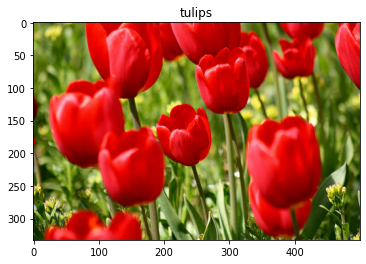

In [5]:
get_label_name = metadata.features['label'].int2str

image, label = next(iter(train_ds))
_ = plt.imshow(image)
_ = plt.title(get_label_name(label))

## Use Keras preprocessing layers

### Resizing and rescaling


You can use the Keras preprocessing layers to resize your images to a consistent shape (with `tf.keras.layers.Resizing`), and to rescale pixel values (with `tf.keras.layers.Rescaling`).

In [6]:
IMG_SIZE = 180

resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(IMG_SIZE, IMG_SIZE),
  layers.Rescaling(1./255)
])

Note: The rescaling layer above standardizes pixel values to the `[0, 1]` range. If instead you wanted it to be `[-1, 1]`, you would write `tf.keras.layers.Rescaling(1./127.5, offset=-1)`.


You can visualize the result of applying these layers to an image. 

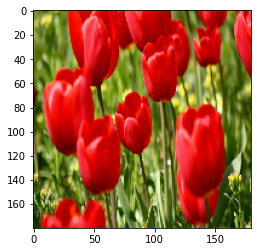

In [7]:
result = resize_and_rescale(image)
_ = plt.imshow(result)

Verify that the pixels are in the `[0, 1]` range:

In [8]:
print("Min and max pixel values:", result.numpy().min(), result.numpy().max())

Min and max pixel values: 0.0 1.0


### Data augmentation

You can use the Keras preprocessing layers for data augmentation as well, such as `tf.keras.layers.RandomFlip` and `tf.keras.layers.RandomRotation`.

Let's create a few preprocessing layers and apply them repeatedly to the same image.

In [9]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])

In [10]:
# Add the image to a batch.
image = tf.cast(tf.expand_dims(image, 0), tf.float32)

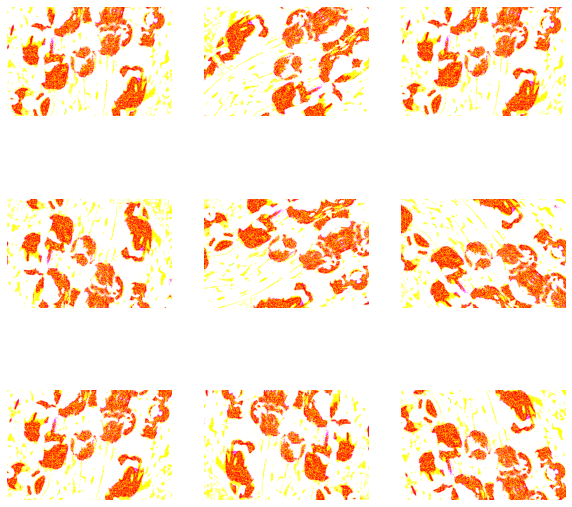

In [11]:
plt.figure(figsize=(10, 10))
for i in range(9):
  augmented_image = data_augmentation(image)
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(augmented_image[0])
  plt.axis("off")

There are a variety of preprocessing layers you can use for data augmentation including `tf.keras.layers.RandomContrast`, `tf.keras.layers.RandomCrop`, `tf.keras.layers.RandomZoom`, and others.

### Two options to use the Keras preprocessing layers

There are two ways you can use these preprocessing layers, with important trade-offs.

#### Option 1: Make the preprocessing layers part of your model

In [12]:
model = tf.keras.Sequential([
  # Add the preprocessing layers you created earlier.
  resize_and_rescale,
  data_augmentation,
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  # Rest of your model.
])

There are two important points to be aware of in this case:

* Data augmentation will run on-device, synchronously with the rest of your layers, and benefit from GPU acceleration.

* When you export your model using `model.save`, the preprocessing layers will be saved along with the rest of your model. If you later deploy this model, it will automatically standardize images (according to the configuration of your layers). This can save you from the effort of having to reimplement that logic server-side.

Note: Data augmentation is inactive at test time so input images will only be augmented during calls to `Model.fit` (not `Model.evaluate` or `Model.predict`).

#### Option 2: Apply the preprocessing layers to your dataset

In [13]:
aug_ds = train_ds.map(
  lambda x, y: (resize_and_rescale(x, training=True), y))

With this approach, you use `Dataset.map` to create a dataset that yields batches of augmented images. In this case:

* Data augmentation will happen asynchronously on the CPU, and is non-blocking. You can overlap the training of your model on the GPU with data preprocessing, using `Dataset.prefetch`, shown below.
* In this case the preprocessing layers will not be exported with the model when you call `Model.save`. You will need to attach them to your model before saving it or reimplement them server-side. After training, you can attach the preprocessing layers before export.


You can find an example of the first option in the [Image classification](classification.ipynb) tutorial. Let's demonstrate the second option here.

### Apply the preprocessing layers to the datasets

Configure the training, validation, and test datasets with the Keras preprocessing layers you created earlier. You will also configure the datasets for performance, using parallel reads and buffered prefetching to yield batches from disk without I/O become blocking. (Learn more dataset performance in the [Better performance with the tf.data API](https://www.tensorflow.org/guide/data_performance) guide.)

Note: Data augmentation should only be applied to the training set.

In [14]:
batch_size = 32
AUTOTUNE = tf.data.AUTOTUNE

def prepare(ds, shuffle=False, augment=False):
  # Resize and rescale all datasets.
  ds = ds.map(lambda x, y: (resize_and_rescale(x), y), 
              num_parallel_calls=AUTOTUNE)

  if shuffle:
    ds = ds.shuffle(1000)

  # Batch all datasets.
  ds = ds.batch(batch_size)

  # Use data augmentation only on the training set.
  if augment:
    ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), 
                num_parallel_calls=AUTOTUNE)

  # Use buffered prefetching on all datasets.
  return ds.prefetch(buffer_size=AUTOTUNE)

In [15]:
train_ds = prepare(train_ds, shuffle=True, augment=True)
val_ds = prepare(val_ds)
test_ds = prepare(test_ds)

### Train a model

For completeness, you will now train a model using the datasets you have just prepared.

The [Sequential](https://www.tensorflow.org/guide/keras/sequential_model) model consists of three convolution blocks (`tf.keras.layers.Conv2D`) with a max pooling layer (`tf.keras.layers.MaxPooling2D`) in each of them. There's a fully-connected layer (`tf.keras.layers.Dense`) with 128 units on top of it that is activated by a ReLU activation function (`'relu'`). This model has not been tuned for accuracy (the goal is to show you the mechanics).

In [16]:
model = tf.keras.Sequential([
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

Choose the `tf.keras.optimizers.Adam` optimizer and `tf.keras.losses.SparseCategoricalCrossentropy` loss function. To view training and validation accuracy for each training epoch, pass the `metrics` argument to `Model.compile`.

In [17]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

Train for a few epochs:

In [18]:
epochs=5
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/5


 1/92 [..............................] - ETA: 15:10 - loss: 1.6074 - accuracy: 0.2188

 6/92 [>.............................] - ETA: 0s - loss: 1.7895 - accuracy: 0.2500   

11/92 [==>...........................] - ETA: 1s - loss: 1.6734 - accuracy: 0.2642

13/92 [===>..........................] - ETA: 1s - loss: 1.6391 - accuracy: 0.2716

15/92 [===>..........................] - ETA: 1s - loss: 1.6115 - accuracy: 0.2833

17/92 [====>.........................] - ETA: 1s - loss: 1.5810 - accuracy: 0.3051

19/92 [=====>........................] - ETA: 2s - loss: 1.5644 - accuracy: 0.3224

21/92 [=====>........................] - ETA: 2s - loss: 1.5481 - accuracy: 0.3304

22/92 [======>.......................] - ETA: 2s - loss: 1.5443 - accuracy: 0.3295

23/92 [======>.......................] - ETA: 2s - loss: 1.5259 - accuracy: 0.3383

24/92 [======>.......................] - ETA: 2s - loss: 1.5099 - accuracy: 0.3451

26/92 [=======>......................] - ETA: 2s - loss: 1.5077 - accuracy: 0.3462

28/92 [========>.....................] - ETA: 2s - loss: 1.5006 - accuracy: 0.3504

29/92 [========>.....................] - ETA: 2s - loss: 1.4943 - accuracy: 0.3545

31/92 [=========>....................] - ETA: 2s - loss: 1.4803 - accuracy: 0.3629

33/92 [=========>....................] - ETA: 2s - loss: 1.4683 - accuracy: 0.3655

34/92 [==========>...................] - ETA: 5s - loss: 1.4595 - accuracy: 0.3713

36/92 [==========>...................] - ETA: 4s - loss: 1.4446 - accuracy: 0.3837

37/92 [===========>..................] - ETA: 8s - loss: 1.4406 - accuracy: 0.3851

39/92 [===========>..................] - ETA: 7s - loss: 1.4383 - accuracy: 0.3902

41/92 [============>.................] - ETA: 7s - loss: 1.4276 - accuracy: 0.3933

42/92 [============>.................] - ETA: 7s - loss: 1.4208 - accuracy: 0.3966

43/92 [=============>................] - ETA: 6s - loss: 1.4178 - accuracy: 0.3953

44/92 [=============>................] - ETA: 6s - loss: 1.4131 - accuracy: 0.3970

45/92 [=============>................] - ETA: 6s - loss: 1.4072 - accuracy: 0.3993

47/92 [==============>...............] - ETA: 5s - loss: 1.3976 - accuracy: 0.4062

49/92 [==============>...............] - ETA: 5s - loss: 1.3882 - accuracy: 0.4114

51/92 [===============>..............] - ETA: 5s - loss: 1.3782 - accuracy: 0.4148

53/92 [================>.............] - ETA: 4s - loss: 1.3714 - accuracy: 0.4151

54/92 [================>.............] - ETA: 4s - loss: 1.3650 - accuracy: 0.4167

55/92 [================>.............] - ETA: 4s - loss: 1.3711 - accuracy: 0.4136

57/92 [=================>............] - ETA: 4s - loss: 1.3586 - accuracy: 0.4205

59/92 [==================>...........] - ETA: 3s - loss: 1.3545 - accuracy: 0.4258

60/92 [==================>...........] - ETA: 3s - loss: 1.3507 - accuracy: 0.4281

64/92 [===================>..........] - ETA: 2s - loss: 1.3420 - accuracy: 0.4282

66/92 [====================>.........] - ETA: 2s - loss: 1.3385 - accuracy: 0.4295

69/92 [=====================>........] - ETA: 2s - loss: 1.3304 - accuracy: 0.4334

72/92 [======================>.......] - ETA: 1s - loss: 1.3204 - accuracy: 0.4379

76/92 [=======================>......] - ETA: 1s - loss: 1.3103 - accuracy: 0.4470

78/92 [========================>.....] - ETA: 1s - loss: 1.3055 - accuracy: 0.4495

81/92 [=========================>....] - ETA: 0s - loss: 1.2993 - accuracy: 0.4529

84/92 [==========================>...] - ETA: 0s - loss: 1.2951 - accuracy: 0.4561

87/92 [===========================>..] - ETA: 0s - loss: 1.2891 - accuracy: 0.4598

90/92 [============================>.] - ETA: 0s - loss: 1.2866 - accuracy: 0.4608

92/92 [==============================] - ETA: 0s - loss: 1.2814 - accuracy: 0.4632

92/92 [==============================] - 19s 96ms/step - loss: 1.2814 - accuracy: 0.4632 - val_loss: 1.1246 - val_accuracy: 0.5804


Epoch 2/5


 1/92 [..............................] - ETA: 39s - loss: 1.1410 - accuracy: 0.6250

 5/92 [>.............................] - ETA: 1s - loss: 1.1238 - accuracy: 0.5188 

 8/92 [=>............................] - ETA: 1s - loss: 1.0566 - accuracy: 0.5469

 9/92 [=>............................] - ETA: 2s - loss: 1.0969 - accuracy: 0.5451

10/92 [==>...........................] - ETA: 2s - loss: 1.0969 - accuracy: 0.5375

14/92 [===>..........................] - ETA: 1s - loss: 1.0997 - accuracy: 0.5379

17/92 [====>.........................] - ETA: 2s - loss: 1.0979 - accuracy: 0.5423

20/92 [=====>........................] - ETA: 1s - loss: 1.1037 - accuracy: 0.5469

22/92 [======>.......................] - ETA: 1s - loss: 1.1087 - accuracy: 0.5483

24/92 [======>.......................] - ETA: 1s - loss: 1.1142 - accuracy: 0.5495

27/92 [=======>......................] - ETA: 1s - loss: 1.1158 - accuracy: 0.5440

30/92 [========>.....................] - ETA: 1s - loss: 1.1142 - accuracy: 0.5500

32/92 [=========>....................] - ETA: 1s - loss: 1.1181 - accuracy: 0.5527

35/92 [==========>...................] - ETA: 1s - loss: 1.1083 - accuracy: 0.5545

37/92 [===========>..................] - ETA: 1s - loss: 1.1071 - accuracy: 0.5600

40/92 [============>.................] - ETA: 1s - loss: 1.1064 - accuracy: 0.5633

43/92 [=============>................] - ETA: 1s - loss: 1.1037 - accuracy: 0.5596

46/92 [==============>...............] - ETA: 1s - loss: 1.1033 - accuracy: 0.5611

48/92 [==============>...............] - ETA: 1s - loss: 1.1092 - accuracy: 0.5579

50/92 [===============>..............] - ETA: 1s - loss: 1.1153 - accuracy: 0.5537

53/92 [================>.............] - ETA: 1s - loss: 1.1150 - accuracy: 0.5489

56/92 [=================>............] - ETA: 0s - loss: 1.1173 - accuracy: 0.5491

59/92 [==================>...........] - ETA: 0s - loss: 1.1171 - accuracy: 0.5482

63/92 [===================>..........] - ETA: 0s - loss: 1.1104 - accuracy: 0.5531

66/92 [====================>.........] - ETA: 0s - loss: 1.1028 - accuracy: 0.5592

67/92 [====================>.........] - ETA: 0s - loss: 1.0979 - accuracy: 0.5620

72/92 [======================>.......] - ETA: 0s - loss: 1.0931 - accuracy: 0.5647

75/92 [=======================>......] - ETA: 0s - loss: 1.0815 - accuracy: 0.5696

80/92 [=========================>....] - ETA: 0s - loss: 1.0783 - accuracy: 0.5699

83/92 [==========================>...] - ETA: 0s - loss: 1.0759 - accuracy: 0.5719

88/92 [===========================>..] - ETA: 0s - loss: 1.0697 - accuracy: 0.5732

91/92 [============================>.] - ETA: 0s - loss: 1.0678 - accuracy: 0.5755

92/92 [==============================] - 3s 26ms/step - loss: 1.0684 - accuracy: 0.5753 - val_loss: 0.9848 - val_accuracy: 0.6213


Epoch 3/5


 1/92 [..............................] - ETA: 36s - loss: 1.2205 - accuracy: 0.3750

 5/92 [>.............................] - ETA: 1s - loss: 1.0084 - accuracy: 0.5625 

 7/92 [=>............................] - ETA: 1s - loss: 0.9951 - accuracy: 0.5714

 8/92 [=>............................] - ETA: 2s - loss: 1.0366 - accuracy: 0.5547

11/92 [==>...........................] - ETA: 1s - loss: 1.0270 - accuracy: 0.5568

13/92 [===>..........................] - ETA: 1s - loss: 1.0225 - accuracy: 0.5649

16/92 [====>.........................] - ETA: 1s - loss: 1.0255 - accuracy: 0.5684

19/92 [=====>........................] - ETA: 1s - loss: 1.0224 - accuracy: 0.5724

21/92 [=====>........................] - ETA: 1s - loss: 1.0219 - accuracy: 0.5774

23/92 [======>.......................] - ETA: 1s - loss: 1.0114 - accuracy: 0.5897

25/92 [=======>......................] - ETA: 1s - loss: 1.0109 - accuracy: 0.5875

27/92 [=======>......................] - ETA: 1s - loss: 1.0068 - accuracy: 0.5891

30/92 [========>.....................] - ETA: 1s - loss: 1.0292 - accuracy: 0.5833

32/92 [=========>....................] - ETA: 1s - loss: 1.0285 - accuracy: 0.5879

34/92 [==========>...................] - ETA: 1s - loss: 1.0179 - accuracy: 0.5919

35/92 [==========>...................] - ETA: 1s - loss: 1.0121 - accuracy: 0.5911

38/92 [===========>..................] - ETA: 1s - loss: 1.0199 - accuracy: 0.5847

40/92 [============>.................] - ETA: 1s - loss: 1.0116 - accuracy: 0.5867

43/92 [=============>................] - ETA: 1s - loss: 1.0126 - accuracy: 0.5872

46/92 [==============>...............] - ETA: 1s - loss: 1.0014 - accuracy: 0.5904

48/92 [==============>...............] - ETA: 1s - loss: 1.0004 - accuracy: 0.5918

51/92 [===============>..............] - ETA: 1s - loss: 0.9890 - accuracy: 0.5968

53/92 [================>.............] - ETA: 1s - loss: 0.9835 - accuracy: 0.5991

56/92 [=================>............] - ETA: 1s - loss: 0.9894 - accuracy: 0.5971

58/92 [=================>............] - ETA: 0s - loss: 0.9913 - accuracy: 0.5981

60/92 [==================>...........] - ETA: 0s - loss: 0.9891 - accuracy: 0.5984

62/92 [===================>..........] - ETA: 0s - loss: 0.9855 - accuracy: 0.5993

66/92 [====================>.........] - ETA: 0s - loss: 0.9843 - accuracy: 0.6027

69/92 [=====================>........] - ETA: 0s - loss: 0.9828 - accuracy: 0.6024

72/92 [======================>.......] - ETA: 0s - loss: 0.9794 - accuracy: 0.6063

74/92 [=======================>......] - ETA: 0s - loss: 0.9769 - accuracy: 0.6060

77/92 [========================>.....] - ETA: 0s - loss: 0.9719 - accuracy: 0.6100

80/92 [=========================>....] - ETA: 0s - loss: 0.9714 - accuracy: 0.6102

84/92 [==========================>...] - ETA: 0s - loss: 0.9704 - accuracy: 0.6120

87/92 [===========================>..] - ETA: 0s - loss: 0.9714 - accuracy: 0.6114

89/92 [============================>.] - ETA: 0s - loss: 0.9701 - accuracy: 0.6110

92/92 [==============================] - 3s 28ms/step - loss: 0.9701 - accuracy: 0.6100 - val_loss: 1.0106 - val_accuracy: 0.6185


Epoch 4/5


 1/92 [..............................] - ETA: 40s - loss: 0.9073 - accuracy: 0.6562

 6/92 [>.............................] - ETA: 1s - loss: 0.9795 - accuracy: 0.6094 

 8/92 [=>............................] - ETA: 1s - loss: 0.9525 - accuracy: 0.6250

 9/92 [=>............................] - ETA: 1s - loss: 0.9690 - accuracy: 0.6250

13/92 [===>..........................] - ETA: 1s - loss: 0.9805 - accuracy: 0.6082

16/92 [====>.........................] - ETA: 1s - loss: 0.9929 - accuracy: 0.6113

18/92 [====>.........................] - ETA: 1s - loss: 1.0047 - accuracy: 0.6076

20/92 [=====>........................] - ETA: 1s - loss: 0.9998 - accuracy: 0.6109

23/92 [======>.......................] - ETA: 1s - loss: 0.9949 - accuracy: 0.6141

25/92 [=======>......................] - ETA: 1s - loss: 0.9918 - accuracy: 0.6162

27/92 [=======>......................] - ETA: 1s - loss: 0.9937 - accuracy: 0.6169

30/92 [========>.....................] - ETA: 1s - loss: 0.9805 - accuracy: 0.6219

32/92 [=========>....................] - ETA: 1s - loss: 0.9841 - accuracy: 0.6152

34/92 [==========>...................] - ETA: 1s - loss: 0.9828 - accuracy: 0.6176

38/92 [===========>..................] - ETA: 1s - loss: 0.9635 - accuracy: 0.6258

40/92 [============>.................] - ETA: 1s - loss: 0.9647 - accuracy: 0.6227

42/92 [============>.................] - ETA: 1s - loss: 0.9636 - accuracy: 0.6228

44/92 [=============>................] - ETA: 1s - loss: 0.9478 - accuracy: 0.6307

47/92 [==============>...............] - ETA: 1s - loss: 0.9427 - accuracy: 0.6330

50/92 [===============>..............] - ETA: 1s - loss: 0.9374 - accuracy: 0.6356

52/92 [===============>..............] - ETA: 1s - loss: 0.9403 - accuracy: 0.6340

54/92 [================>.............] - ETA: 0s - loss: 0.9398 - accuracy: 0.6366

57/92 [=================>............] - ETA: 0s - loss: 0.9350 - accuracy: 0.6398

59/92 [==================>...........] - ETA: 0s - loss: 0.9370 - accuracy: 0.6367

61/92 [==================>...........] - ETA: 0s - loss: 0.9313 - accuracy: 0.6404

65/92 [====================>.........] - ETA: 0s - loss: 0.9199 - accuracy: 0.6442

67/92 [====================>.........] - ETA: 0s - loss: 0.9148 - accuracy: 0.6446

69/92 [=====================>........] - ETA: 0s - loss: 0.9160 - accuracy: 0.6454

72/92 [======================>.......] - ETA: 0s - loss: 0.9109 - accuracy: 0.6471

76/92 [=======================>......] - ETA: 0s - loss: 0.9085 - accuracy: 0.6472

80/92 [=========================>....] - ETA: 0s - loss: 0.9123 - accuracy: 0.6438

82/92 [=========================>....] - ETA: 0s - loss: 0.9099 - accuracy: 0.6460

85/92 [==========================>...] - ETA: 0s - loss: 0.9070 - accuracy: 0.6478

88/92 [===========================>..] - ETA: 0s - loss: 0.9026 - accuracy: 0.6491

92/92 [==============================] - ETA: 0s - loss: 0.9046 - accuracy: 0.6502

92/92 [==============================] - 3s 26ms/step - loss: 0.9046 - accuracy: 0.6502 - val_loss: 0.9455 - val_accuracy: 0.6076


Epoch 5/5


 1/92 [..............................] - ETA: 34s - loss: 0.8021 - accuracy: 0.6562

 5/92 [>.............................] - ETA: 1s - loss: 0.9313 - accuracy: 0.6000 

 8/92 [=>............................] - ETA: 2s - loss: 0.9420 - accuracy: 0.6133

10/92 [==>...........................] - ETA: 2s - loss: 0.9337 - accuracy: 0.6250

14/92 [===>..........................] - ETA: 1s - loss: 0.9433 - accuracy: 0.6317

16/92 [====>.........................] - ETA: 1s - loss: 0.9433 - accuracy: 0.6250

18/92 [====>.........................] - ETA: 1s - loss: 0.9265 - accuracy: 0.6354

20/92 [=====>........................] - ETA: 1s - loss: 0.9304 - accuracy: 0.6406

22/92 [======>.......................] - ETA: 1s - loss: 0.9202 - accuracy: 0.6506

24/92 [======>.......................] - ETA: 1s - loss: 0.9166 - accuracy: 0.6523

26/92 [=======>......................] - ETA: 1s - loss: 0.9038 - accuracy: 0.6587

28/92 [========>.....................] - ETA: 1s - loss: 0.9179 - accuracy: 0.6473

30/92 [========>.....................] - ETA: 1s - loss: 0.9124 - accuracy: 0.6521

32/92 [=========>....................] - ETA: 1s - loss: 0.9173 - accuracy: 0.6484

34/92 [==========>...................] - ETA: 1s - loss: 0.9094 - accuracy: 0.6535

35/92 [==========>...................] - ETA: 1s - loss: 0.9082 - accuracy: 0.6554

37/92 [===========>..................] - ETA: 1s - loss: 0.9023 - accuracy: 0.6613

39/92 [===========>..................] - ETA: 1s - loss: 0.9065 - accuracy: 0.6627

42/92 [============>.................] - ETA: 1s - loss: 0.8951 - accuracy: 0.6682

44/92 [=============>................] - ETA: 1s - loss: 0.8963 - accuracy: 0.6669

46/92 [==============>...............] - ETA: 1s - loss: 0.8923 - accuracy: 0.6651

49/92 [==============>...............] - ETA: 1s - loss: 0.8872 - accuracy: 0.6652

52/92 [===============>..............] - ETA: 1s - loss: 0.8855 - accuracy: 0.6647

55/92 [================>.............] - ETA: 1s - loss: 0.8854 - accuracy: 0.6642

57/92 [=================>............] - ETA: 0s - loss: 0.8814 - accuracy: 0.6656

59/92 [==================>...........] - ETA: 0s - loss: 0.8823 - accuracy: 0.6653

63/92 [===================>..........] - ETA: 0s - loss: 0.8846 - accuracy: 0.6632

66/92 [====================>.........] - ETA: 0s - loss: 0.8827 - accuracy: 0.6648

67/92 [====================>.........] - ETA: 0s - loss: 0.8766 - accuracy: 0.6674

71/92 [======================>.......] - ETA: 0s - loss: 0.8708 - accuracy: 0.6712

75/92 [=======================>......] - ETA: 0s - loss: 0.8721 - accuracy: 0.6712

76/92 [=======================>......] - ETA: 0s - loss: 0.8712 - accuracy: 0.6715

80/92 [=========================>....] - ETA: 0s - loss: 0.8748 - accuracy: 0.6711

83/92 [==========================>...] - ETA: 0s - loss: 0.8738 - accuracy: 0.6706

85/92 [==========================>...] - ETA: 0s - loss: 0.8742 - accuracy: 0.6713

87/92 [===========================>..] - ETA: 0s - loss: 0.8743 - accuracy: 0.6706

92/92 [==============================] - 3s 27ms/step - loss: 0.8676 - accuracy: 0.6717 - val_loss: 0.9243 - val_accuracy: 0.6512


In [19]:
loss, acc = model.evaluate(test_ds)
print("Accuracy", acc)

 1/12 [=>............................] - ETA: 8s - loss: 0.7680 - accuracy: 0.6875

 5/12 [===========>..................] - ETA: 0s - loss: 0.8347 - accuracy: 0.6687

 9/12 [=====================>........] - ETA: 0s - loss: 0.8164 - accuracy: 0.6736

12/12 [==============================] - 1s 14ms/step - loss: 0.8008 - accuracy: 0.6839


Accuracy 0.6839237213134766


### Custom data augmentation

You can also create custom data augmentation layers.

This section of the tutorial shows two ways of doing so:

- First, you will create a `tf.keras.layers.Lambda` layer. This is a good way to write concise code.
- Next, you will write a new layer via [subclassing](https://www.tensorflow.org/guide/keras/custom_layers_and_models), which gives you more control.

Both layers will randomly invert the colors in an image, according to some probability.

In [20]:
def random_invert_img(x, p=0.5):
  if  tf.random.uniform([]) < p:
    x = (255-x)
  else:
    x
  return x

In [21]:
def random_invert(factor=0.5):
  return layers.Lambda(lambda x: random_invert_img(x, factor))

random_invert = random_invert()

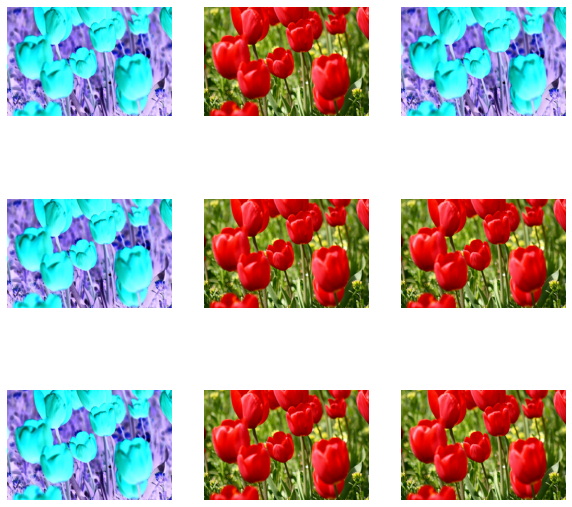

In [22]:
plt.figure(figsize=(10, 10))
for i in range(9):
  augmented_image = random_invert(image)
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(augmented_image[0].numpy().astype("uint8"))
  plt.axis("off")

Next, implement a custom layer by [subclassing](https://www.tensorflow.org/guide/keras/custom_layers_and_models):

In [23]:
class RandomInvert(layers.Layer):
  def __init__(self, factor=0.5, **kwargs):
    super().__init__(**kwargs)
    self.factor = factor

  def call(self, x):
    return random_invert_img(x)

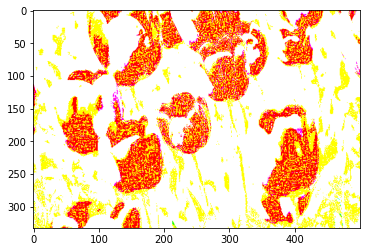

In [24]:
_ = plt.imshow(RandomInvert()(image)[0])

Both of these layers can be used as described in options 1 and 2 above.

## Using tf.image

The above Keras preprocessing utilities are convenient. But, for finer control, you can write your own data augmentation pipelines or layers using `tf.data` and `tf.image`. (You may also want to check out [TensorFlow Addons Image: Operations](https://www.tensorflow.org/addons/tutorials/image_ops) and [TensorFlow I/O: Color Space Conversions](https://www.tensorflow.org/io/tutorials/colorspace).)

Since the flowers dataset was previously configured with data augmentation, let's reimport it to start fresh:

In [25]:
(train_ds, val_ds, test_ds), metadata = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

Retrieve an image to work with:

2022-02-23 02:25:23.782065: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


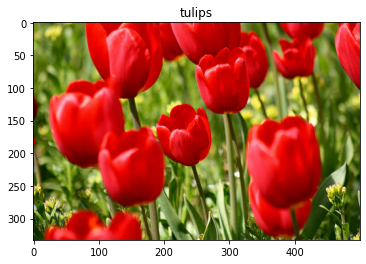

In [26]:
image, label = next(iter(train_ds))
_ = plt.imshow(image)
_ = plt.title(get_label_name(label))

Let's use the following function to visualize and compare the original and augmented images side-by-side:

In [27]:
def visualize(original, augmented):
  fig = plt.figure()
  plt.subplot(1,2,1)
  plt.title('Original image')
  plt.imshow(original)

  plt.subplot(1,2,2)
  plt.title('Augmented image')
  plt.imshow(augmented)

### Data augmentation

#### Flip an image

Flip an image either vertically or horizontally with `tf.image.flip_left_right`:

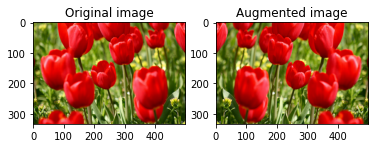

In [28]:
flipped = tf.image.flip_left_right(image)
visualize(image, flipped)

#### Grayscale an image

You can grayscale an image with `tf.image.rgb_to_grayscale`:

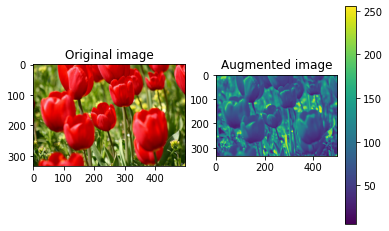

In [29]:
grayscaled = tf.image.rgb_to_grayscale(image)
visualize(image, tf.squeeze(grayscaled))
_ = plt.colorbar()

#### Saturate an image

Saturate an image with `tf.image.adjust_saturation` by providing a saturation factor:

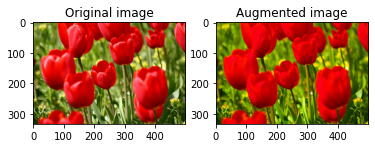

In [30]:
saturated = tf.image.adjust_saturation(image, 3)
visualize(image, saturated)

#### Change image brightness

Change the brightness of image with `tf.image.adjust_brightness` by providing a brightness factor:

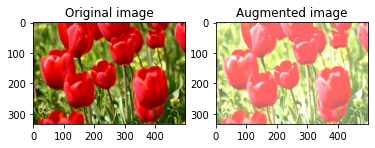

In [31]:
bright = tf.image.adjust_brightness(image, 0.4)
visualize(image, bright)

#### Center crop an image

Crop the image from center up to the image part you desire using `tf.image.central_crop`:

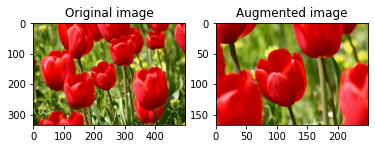

In [32]:
cropped = tf.image.central_crop(image, central_fraction=0.5)
visualize(image, cropped)

#### Rotate an image

Rotate an image by 90 degrees with `tf.image.rot90`:

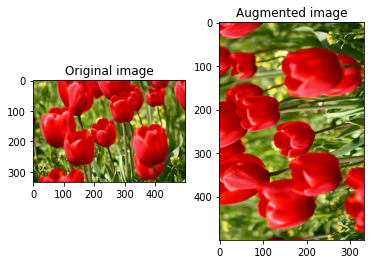

In [33]:
rotated = tf.image.rot90(image)
visualize(image, rotated)

### Random transformations

Warning: There are two sets of random image operations: `tf.image.random*` and `tf.image.stateless_random*`. Using `tf.image.random*` operations is strongly discouraged as they use the old RNGs from TF 1.x. Instead, please use the random image operations introduced in this tutorial. For more information, refer to [Random number generation](../../guide/random_numbers.ipynb).

Applying random transformations to the images can further help generalize and expand the dataset. The current `tf.image` API provides eight such random image operations (ops):

*   [`tf.image.stateless_random_brightness`](https://www.tensorflow.org/api_docs/python/tf/image/stateless_random_brightness)
*   [`tf.image.stateless_random_contrast`](https://www.tensorflow.org/api_docs/python/tf/image/stateless_random_contrast)
*   [`tf.image.stateless_random_crop`](https://www.tensorflow.org/api_docs/python/tf/image/stateless_random_crop)
*   [`tf.image.stateless_random_flip_left_right`](https://www.tensorflow.org/api_docs/python/tf/image/stateless_random_flip_left_right)
*   [`tf.image.stateless_random_flip_up_down`](https://www.tensorflow.org/api_docs/python/tf/image/stateless_random_flip_up_down)
*   [`tf.image.stateless_random_hue`](https://www.tensorflow.org/api_docs/python/tf/image/stateless_random_hue)
*   [`tf.image.stateless_random_jpeg_quality`](https://www.tensorflow.org/api_docs/python/tf/image/stateless_random_jpeg_quality)
*   [`tf.image.stateless_random_saturation`](https://www.tensorflow.org/api_docs/python/tf/image/stateless_random_saturation)

These random image ops are purely functional: the output only depends on the input. This makes them simple to use in high performance, deterministic input pipelines. They require a `seed` value be input each step. Given the same `seed`, they return the same results independent of how many times they are called.

Note: `seed` is a `Tensor` of shape `(2,)`  whose values are any integers.

In the following sections, you will:
1.   Go over examples of using random image operations to transform an image.
2.   Demonstrate how to apply random transformations to a training dataset.

#### Randomly change image brightness

Randomly change the brightness of `image` using `tf.image.stateless_random_brightness` by providing a brightness factor and `seed`. The brightness factor is chosen randomly in the range `[-max_delta, max_delta)` and is associated with the given `seed`.

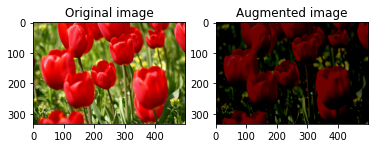

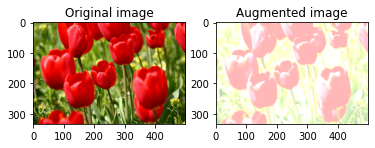

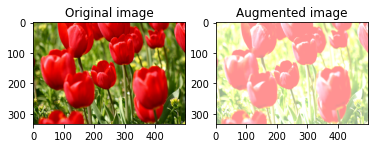

In [34]:
for i in range(3):
  seed = (i, 0)  # tuple of size (2,)
  stateless_random_brightness = tf.image.stateless_random_brightness(
      image, max_delta=0.95, seed=seed)
  visualize(image, stateless_random_brightness)

#### Randomly change image contrast

Randomly change the contrast of `image` using `tf.image.stateless_random_contrast` by providing a contrast range and `seed`. The contrast range is chosen randomly in the interval `[lower, upper]` and is associated with the given `seed`.

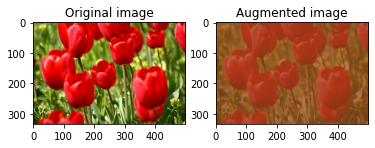

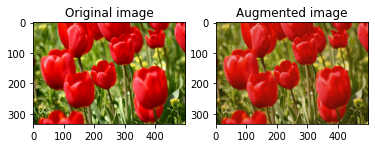

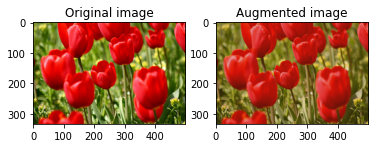

In [35]:
for i in range(3):
  seed = (i, 0)  # tuple of size (2,)
  stateless_random_contrast = tf.image.stateless_random_contrast(
      image, lower=0.1, upper=0.9, seed=seed)
  visualize(image, stateless_random_contrast)

#### Randomly crop an image

Randomly crop `image` using `tf.image.stateless_random_crop` by providing target `size` and `seed`. The portion that gets cropped out of `image` is at a randomly chosen offset and is associated with the given `seed`.

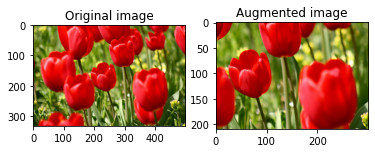

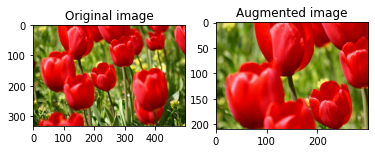

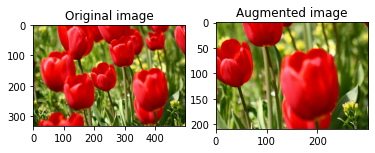

In [36]:
for i in range(3):
  seed = (i, 0)  # tuple of size (2,)
  stateless_random_crop = tf.image.stateless_random_crop(
      image, size=[210, 300, 3], seed=seed)
  visualize(image, stateless_random_crop)

### Apply augmentation to a dataset

Let's first download the image dataset again in case they are modified in the previous sections.

In [37]:
(train_datasets, val_ds, test_ds), metadata = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

Next, define a utility function for resizing and rescaling the images. This function will be used in unifying the size and scale of images in the dataset:

In [38]:
def resize_and_rescale(image, label):
  image = tf.cast(image, tf.float32)
  image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
  image = (image / 255.0)
  return image, label

Let's also define the `augment` function that can apply the random transformations to the images. This function will be used on the dataset in the next step.

In [39]:
def augment(image_label, seed):
  image, label = image_label
  image, label = resize_and_rescale(image, label)
  image = tf.image.resize_with_crop_or_pad(image, IMG_SIZE + 6, IMG_SIZE + 6)
  # Make a new seed.
  new_seed = tf.random.experimental.stateless_split(seed, num=1)[0, :]
  # Random crop back to the original size.
  image = tf.image.stateless_random_crop(
      image, size=[IMG_SIZE, IMG_SIZE, 3], seed=seed)
  # Random brightness.
  image = tf.image.stateless_random_brightness(
      image, max_delta=0.5, seed=new_seed)
  image = tf.clip_by_value(image, 0, 1)
  return image, label

#### Option 1: Using tf.data.experimental.Counter

Create a `tf.data.experimental.Counter` object (let's call it `counter`) and `Dataset.zip` the dataset with `(counter, counter)`. This will ensure that each image in the dataset gets associated with a unique value (of shape `(2,)`) based on `counter` which later can get passed into the `augment` function as the `seed` value for random transformations.

In [40]:
# Create a `Counter` object and `Dataset.zip` it together with the training set.
counter = tf.data.experimental.Counter()
train_ds = tf.data.Dataset.zip((train_datasets, (counter, counter)))

Map the `augment` function to the training dataset:

In [41]:
train_ds = (
    train_ds
    .shuffle(1000)
    .map(augment, num_parallel_calls=AUTOTUNE)
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)

In [42]:
val_ds = (
    val_ds
    .map(resize_and_rescale, num_parallel_calls=AUTOTUNE)
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)

In [43]:
test_ds = (
    test_ds
    .map(resize_and_rescale, num_parallel_calls=AUTOTUNE)
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)

#### Option 2: Using tf.random.Generator

- Create a `tf.random.Generator` object with an initial `seed` value. Calling the `make_seeds` function on the same generator object always returns a new, unique `seed` value.
- Define a wrapper function that: 1) calls the `make_seeds` function; and 2) passes the newly generated `seed` value into the `augment` function for random transformations.

Note: `tf.random.Generator` objects store RNG state in a `tf.Variable`, which means it can be saved as a [checkpoint](../../guide/checkpoint.ipynb) or in a [SavedModel](../../guide/saved_model.ipynb). For more details, please refer to [Random number generation](../../guide/random_numbers.ipynb).

In [44]:
# Create a generator.
rng = tf.random.Generator.from_seed(123, alg='philox')

In [45]:
# Create a wrapper function for updating seeds.
def f(x, y):
  seed = rng.make_seeds(2)[0]
  image, label = augment((x, y), seed)
  return image, label

Map the wrapper function `f` to the training dataset, and the `resize_and_rescale` function—to the validation and test sets:

In [46]:
train_ds = (
    train_datasets
    .shuffle(1000)
    .map(f, num_parallel_calls=AUTOTUNE)
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)

In [47]:
val_ds = (
    val_ds
    .map(resize_and_rescale, num_parallel_calls=AUTOTUNE)
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)

In [48]:
test_ds = (
    test_ds
    .map(resize_and_rescale, num_parallel_calls=AUTOTUNE)
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)

These datasets can now be used to train a model as shown previously.

## Next steps

This tutorial demonstrated data augmentation using Keras preprocessing layers and `tf.image`.

- To learn how to include preprocessing layers inside your model, refer to the [Image classification](classification.ipynb) tutorial.
- You may also be interested in learning how preprocessing layers can help you classify text, as shown in the [Basic text classification](../keras/text_classification.ipynb) tutorial.
- You can learn more about `tf.data` in this [guide](../../guide/data.ipynb), and you can learn how to configure your input pipelines for performance [here](../../guide/data_performance.ipynb).